torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])
loss:  2.2905995845794678
outputs.shape :  torch.Size([128, 10])
Sample outputs: 
 tensor([[-0.0203,  0.0699, -0.0255, -0.0122,  0.2017,  0.0252, -0.0821,  0.0173,
         -0.0262,  0.0751],
        [-0.0586, -0.0027,  0.0272, -0.1231,  0.0752,  0.0671, -0.0196,  0.1233,
         -0.0059,  0.0016]])
torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])
Epoch [0], val_loss: 0.2240, val_acc: 0.9371
Epoch [1], val_loss: 0.1756, val_acc: 0.9487
Epoch [2], val_loss: 0.1445, val_acc: 0.9560
Epoch [3], val_loss: 0.1643, val_acc: 0.9511
Epoch [4], val_loss: 0.1455, val_acc: 0.9553


Text(0.5, 1.0, 'Accuracy vs. # of epochs')

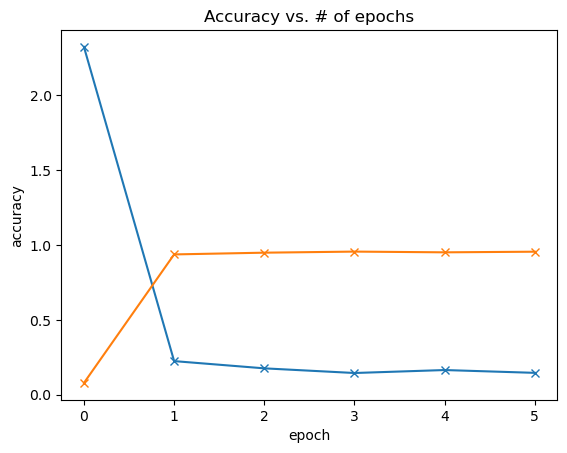

In [2]:
#TRAINING DEEP NEURAL NETWORKS ON CPUS

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
%matplotlib inline

dataset = MNIST('data/', download=True, transform = ToTensor())

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)
print("train_ds.shape: ",train_ds.shape())

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MnistModel(nn.Module):
    #Feedforward neural network with 1 hidden layer
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        #output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        #Flatten the image to tensors
        xb = xb.view(xb.size(0), -1)
        #Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        #Apply activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  #Generate predictions
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  #Generate predictions
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    #Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()    #Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


input_size = 784
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size= num_classes)

#Let's check model paremeters
for t in model.parameters():
    print(t.shape)

#Let's generate some outputs using the model, we take the first batch of 100 images
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('loss: ', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)


#Let's check model paremeters
for t in model.parameters():
    print(t.shape)


#Training and evaluation starts here
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return history

#Before training starts, let's be sure that model parameters and data are on same device
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)


history = [evaluate(model, val_loader)]
history

history += fit(5, 0.5, model, train_loader, val_loader)

losses = [x['val_loss'] for x in history]
plt.plot(losses,'-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. # of epochs')

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. # of epochs')